In [1]:
import sys
from copy import copy
from os.path import join as pjoin
from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson

from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns
proj = ccrs.PlateCarree(central_longitude=180)
trans = ccrs.PlateCarree()

LONLOCATOR = mticker.MultipleLocator(30)
LATLOCATOR = mticker.MultipleLocator(15)
DATEFORMATTER = mdates.DateFormatter("%Y")
CBFORMATTER = mticker.ScalarFormatter(useMathText=True)
CBFORMATTER.set_powerlimits((-2, 2))
EXTENT = (0, 360, 30, -30)

colorseq=['#FFFFFF', '#ceebfd', '#87CEFA', '#4969E1', '#228B22',
          '#90EE90', '#FFDD66', '#FFCC00', '#FF9933',
          '#FF6600', '#FF0000', '#B30000', '#73264d']
cmap = sns.blend_palette(colorseq, as_cmap=True)

from pathlib import Path

d = Path().resolve().parent
sys.path.append(str(d))
import utils
utils.DATA_DIR = r"C:\WorkSpace\data\tc"

palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 1.0)

Load the datasets

In [2]:
ds = xr.open_dataset(r"X:\georisk\HaRIA_B_Wind\projects\tcha\data\derived\genesis\tcgp.1981-2023.nc")
dsmean = ds.groupby(ds.time.dt.month).mean(dim="time")

ds600RH = xr.open_dataset(r"X:\georisk\HaRIA_B_Wind\projects\tcha\data\derived\genesis\600RH\tcgp.1981-2023.nc")
ds600RHmean = ds600RH.groupby(ds600RH.time.dt.month).mean(dim="time")

ds250SH = xr.open_dataset(r"X:\georisk\HaRIA_B_Wind\projects\tcha\data\derived\genesis\250-850\tcgp.1981-2023.nc")
ds250SHmean = ds250SH.groupby(ds250SH.time.dt.month).mean(dim="time")

In [3]:
df = utils.load_ibtracs_df()
df = df[(df.SEASON > 1980) & (df.SEASON < 2024)]
groupdf = df.groupby("DISTURBANCE_ID")
recs = []
for name, group in groupdf:
    # Filter the group for records where MAX_WIND_SPD exceeds the threshold
    exceeding_records = group[group["MAX_WIND_SPD"] >= 34]

    # If there are any records exceeding the threshold, select the first one
    if not exceeding_records.empty:
        rec = exceeding_records.iloc[0]
        recs.append(rec)


Number of TC records: 137983


Create a `DataFrame` of the genesis points, then create `xr.DataArray`s of the longitude, latitude and month of genesis. We use the `xr.DataArray`s to sample variables from the calculated genesis index datasets.

In [4]:

gpdf = pd.DataFrame(recs)
gx = xr.DataArray(gpdf['LON'])
gy = xr.DataArray(gpdf['LAT'])
gt = xr.DataArray(gpdf['TM'].dt.month)
nseasons = df.SEASON.max() - df.SEASON.min() + 1

In [5]:
dfT2018 = dsmean.sel(month=gt, longitude=gx, latitude=gy, method="nearest").to_dataframe()
df600RH = ds600RHmean.sel(month=gt, longitude=gx, latitude=gy, method="nearest").to_dataframe()
df250SH = ds250SHmean.sel(month=gt, longitude=gx, latitude=gy, method="nearest").to_dataframe()
# Use the Hsieh et al. definition for the vorticity parameter
dfH2020 = dfT2018.drop('tcgp', axis=1).rename({"tcgpZ":"tcgp"}, axis=1)
dfs = [df600RH, df250SH, dfH2020, dfT2018]

In [6]:
edge_lats = np.arange(-30, 30.1, 2.5)
edge_lons = np.arange(0, 360.1, 2.5)
clats = edge_lats[:-1] + 1.25
clons = edge_lons[:-1] + 1.25
hh = np.zeros((12, len(clons), len(clats)))

Calculate the mean values of the genesis variables in each grid cell, and calculate the correlations with the number of TC formations. Repeat for each different formulation of genesis index variables.

In [60]:
for name, df in zip(['600 hPa RH', '250-850 Shear', 'H2020', 'T2018'], dfs):
    sum_tcgp = np.zeros((12, len(clons), len(clats)))
    sum_shear = np.zeros((12, len(clons), len(clats)))
    sum_rh = np.zeros((12, len(clons), len(clats)))
    sum_xi = np.zeros((12, len(clons), len(clats)))
    sum_vmax = np.zeros((12, len(clons), len(clats)))
    count = np.zeros((12, len(clons), len(clats)))
    for index, row in df.iterrows():
        if (row['latitude'] < edge_lats.min()) | (row['latitude'] >= edge_lats.max()):
            continue
        if (row['longitude'] < edge_lons.min()) | (row['longitude'] >= edge_lons.max()):
            continue
        if (np.isnan(row['tcgp'])): # | (row['vmax']== np.nan):
            continue
        month_index = int(row['month']) - 1
        lat_index = int((row['latitude'] - edge_lats.min()) // 2.5)
        lon_index = int((row['longitude'] - edge_lons.min()) // 2.5)
        sum_tcgp[month_index, lon_index, lat_index] += row['tcgp']
        sum_vmax[month_index, lon_index, lat_index] += row['vmax']
        sum_rh[month_index, lon_index, lat_index] += row['rh']
        sum_shear[month_index, lon_index, lat_index] += row['shear']
        sum_xi[month_index, lon_index, lat_index] += row['xi']
        count[month_index, lon_index, lat_index] += 1

    average_tcgp = np.divide(sum_tcgp, count, out=np.zeros_like(sum_tcgp), where=count!=0)
    average_vmax = np.divide(sum_vmax, count, out=np.zeros_like(sum_tcgp), where=count!=0)
    average_rh = np.divide(sum_rh, count, out=np.zeros_like(sum_tcgp), where=count!=0)
    average_shear = np.divide(sum_shear, count, out=np.zeros_like(sum_tcgp), where=count!=0)
    average_xi = np.divide(sum_xi, count, out=np.zeros_like(sum_tcgp), where=count!=0)

    tcgp = average_tcgp.flatten()
    shear = average_shear.flatten()
    xi = np.minimum(average_xi.flatten(), 1e-4)
    vpot = average_vmax.flatten()
    rh = average_rh.flatten()
    coslat = np.cos(np.deg2rad(np.tile(clats, (12, len(clons))).reshape(count.shape))).flatten()
    nu = np.maximum((vpot / 40) - 1, 0)
    mu = np.maximum((xi / 2e-5) - 1, 0)
    rho = np.maximum((rh / 40) - 1, 0)
    sigma = np.maximum((1 - (shear / 20)), 0)

    X = np.vstack([count.flatten(), nu, mu, rho, sigma, coslat, tcgp]).T
    cordf = pd.DataFrame(data=X, columns=['ntcs','nu', 'mu', 'rho', 'sigma', 'coslat', 'tcgp'])

    # Print the Spearman correlation coefficients:
    result = cordf.loc[(cordf.ntcs!=0)].corr(method='spearman')
    print(name)
    print(result)

600 hPa RH
            ntcs        nu        mu       rho     sigma    coslat      tcgp
ntcs    1.000000  0.109648  0.141454  0.246862  0.274891 -0.048130  0.390245
nu      0.109648  1.000000 -0.306307  0.480488  0.264033  0.278596  0.414628
mu      0.141454 -0.306307  1.000000 -0.344832  0.037518 -0.648042  0.237864
rho     0.246862  0.480488 -0.344832  1.000000  0.346888  0.290140  0.641734
sigma   0.274891  0.264033  0.037518  0.346888  1.000000  0.137309  0.624390
coslat -0.048130  0.278596 -0.648042  0.290140  0.137309  1.000000 -0.019766
tcgp    0.390245  0.414628  0.237864  0.641734  0.624390 -0.019766  1.000000
250-850 Shear
            ntcs        nu        mu       rho     sigma    coslat      tcgp
ntcs    1.000000  0.109648  0.141454  0.232963  0.277911 -0.048130  0.382485
nu      0.109648  1.000000 -0.306307  0.497304  0.255685  0.278596  0.390073
mu      0.141454 -0.306307  1.000000 -0.388003  0.044876 -0.648042  0.362932
rho     0.232963  0.497304 -0.388003  1.000000  0.3

Repeat the process of calculating mean values of each variable, but using only the T2018 version. We will use this as the basis for the remaining analysis.

In [84]:
sum_tcgp = np.zeros((12, len(clons), len(clats)))
sum_shear = np.zeros((12, len(clons), len(clats)))
sum_rh = np.zeros((12, len(clons), len(clats)))
sum_xi = np.zeros((12, len(clons), len(clats)))
sum_vmax = np.zeros((12, len(clons), len(clats)))
sum_Z = np.zeros((12, len(clons), len(clats)))
count = np.zeros((12, len(clons), len(clats)))
for index, row in dfH2020.iterrows():
    if (row['latitude'] < edge_lats.min()) | (row['latitude'] >= edge_lats.max()):
        continue
    if (row['longitude'] < edge_lons.min()) | (row['longitude'] >= edge_lons.max()):
        continue
    if (np.isnan(row['tcgp'])): # | (row['vmax']== np.nan):
        continue
    month_index = int(row['month']) - 1
    lat_index = int((row['latitude'] - edge_lats.min()) // 2.5)
    lon_index = int((row['longitude'] - edge_lons.min()) // 2.5)
    sum_tcgp[month_index, lon_index, lat_index] += row['tcgp']
    sum_vmax[month_index, lon_index, lat_index] += row['vmax']
    sum_rh[month_index, lon_index, lat_index] += row['rh']
    sum_shear[month_index, lon_index, lat_index] += row['shear']
    sum_xi[month_index, lon_index, lat_index] += row['xi']
    sum_Z[month_index, lon_index, lat_index] += row['Z']
    count[month_index, lon_index, lat_index] += 1

average_tcgp = np.divide(sum_tcgp, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_vmax = np.divide(sum_vmax, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_rh = np.divide(sum_rh, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_shear = np.divide(sum_shear, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_xi = np.divide(sum_xi, count, out=np.zeros_like(sum_tcgp), where=count!=0)
average_Z = np.divide(sum_Z, count, out=np.zeros_like(sum_tcgp), where=count!=0)


tcgp = average_tcgp.flatten()
shear = average_shear.flatten()
xi = np.minimum(average_xi.flatten(), 1e-4)
vpot = average_vmax.flatten()
rh = average_rh.flatten()
ZZ = np.minimum(average_Z.flatten(), 3.5)
coslat = np.cos(np.deg2rad(np.tile(clats, (12, len(clons))).reshape(count.shape))).flatten()
nu = np.maximum((vpot / 40) - 1, 0)
mu = np.maximum((xi / 2e-5) - 1, 0)
rho = np.maximum((rh / 40) - 1, 0)
sigma = np.maximum((1 - (shear / 20)), 0)

In [62]:
# Calculate number of storms in each grid box
for month in range(1, 13):
    tmpdf = gpdf.loc[gpdf.TM.dt.month==month]
    x = tmpdf['LON']
    y = tmpdf['LAT']
    hh[month-1, :, :], xbin, ybin = np.histogram2d(x, y, bins=[edge_lons, edge_lats], density=False)

# Divide by total number of seasons
hh = hh / nseasons

Make a plot of the monthly count of TC genesis points in each grid box. The value represents the total count of storms forming in that grid and month, over the period 1981-2023.

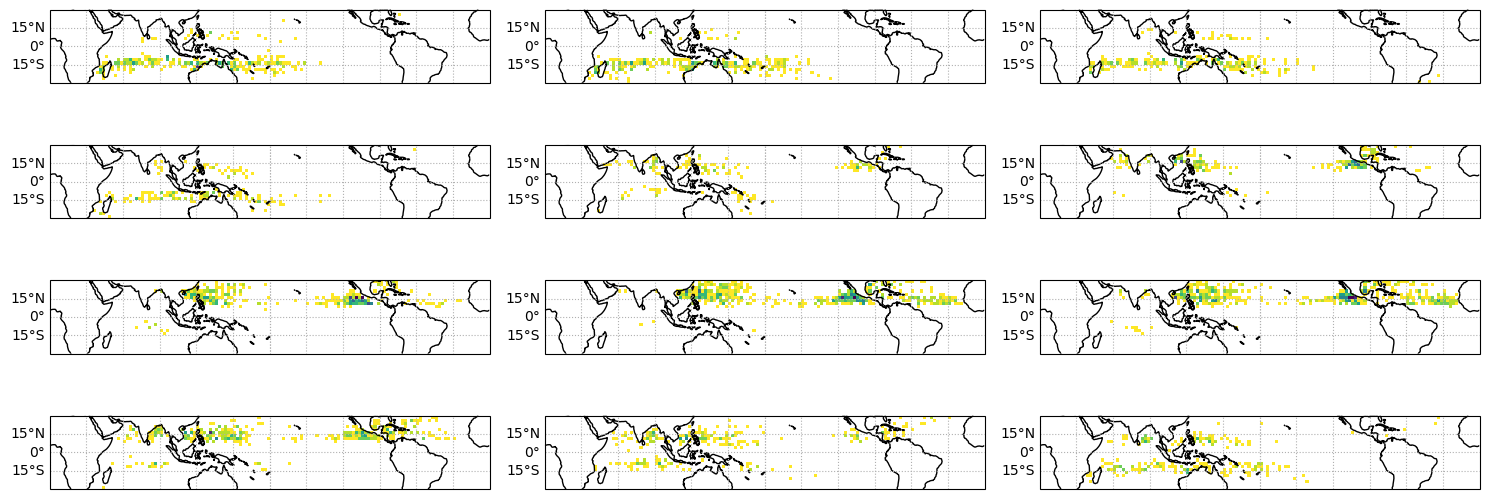

In [63]:
fig, axes = plt.subplots(4, 3, figsize=(15, 6), subplot_kw={"projection": proj}, sharex=True, sharey=True)
xx, yy = np.meshgrid(edge_lons, edge_lats)
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 0.01)
for i, ax in enumerate(axes.flatten()):
    ax.pcolormesh(xx, yy, count[i, :, :].T, transform=trans, cmap=palette, vmin=1, vmax=10)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle=":")
    gl.xlocator = LONLOCATOR
    gl.ylocator = LATLOCATOR
    gl.bottom_labels = False
    gl.right_labels = False
    gl.top_labels = False
    ax.set_extent(EXTENT, crs=trans)
fig.tight_layout()

Create an `xr.DataArray` of the monthly counts. This can be saved to a netCDF file for later analysis.

In [64]:
tcgr = xr.DataArray(
    data=hh,
    coords = {
        'month': np.arange(1, 13),
        'longitude': clons,
        'latitude': clats
    },
    dims=['month', 'longitude', 'latitude'],
    attrs={
        'Description': "Mean number of TC genesis points per year 1981-2023",
        'units': "TCs/year",
        'data_source': "IBTraCS v4.0",
    })

tcgc = xr.DataArray(
    data=count,
    coords = {
        'month': np.arange(1, 13),
        'longitude': clons,
        'latitude': clats
    },
    dims=['month', 'longitude', 'latitude'],
    attrs={
        'Description': "Total number of TC genesis points 1981-2023",
        'units': "TCs",
        'data_source': "IBTraCS v4.0",
    })

Optimization terminated successfully.
         Current function value: 0.081678
         Iterations 12
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                41472
Model:                        Poisson   Df Residuals:                    41467
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Sep 2024   Pseudo R-squ.:                  0.7557
Time:                        14:27:42   Log-Likelihood:                -3387.3
converged:                       True   LL-Null:                       -13866.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0237      0.003      8.686      0.000       0.018       0.029
x2             3.3454      0

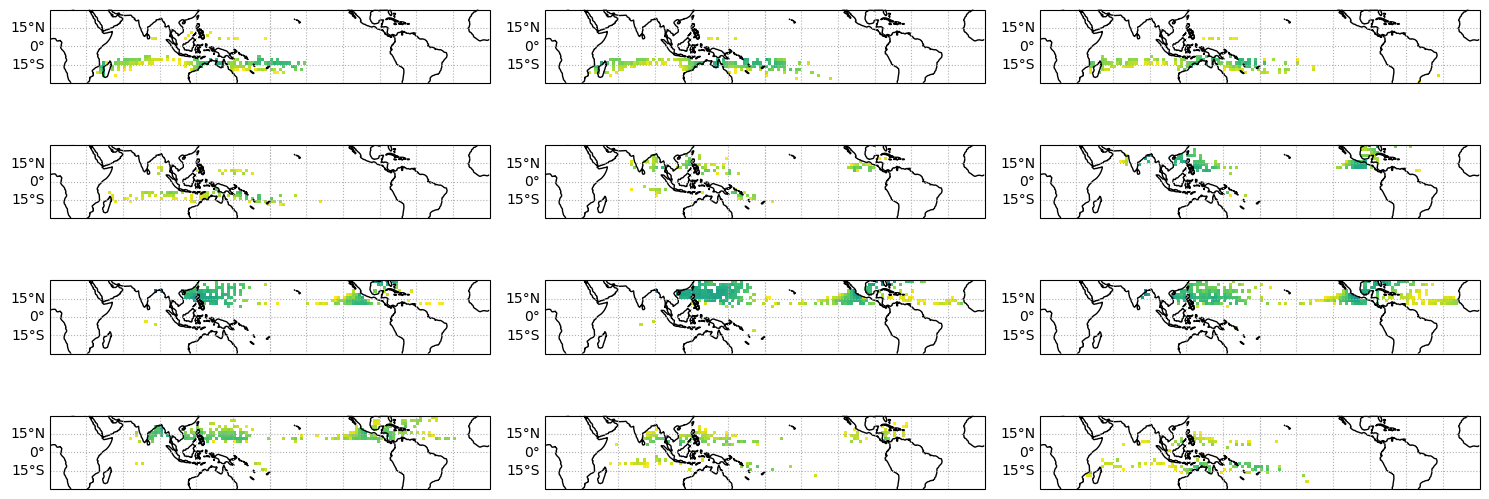

In [90]:
y = count.flatten()
X = np.vstack([vpot, 1/ (1+np.power(ZZ, (-1/0.15))), rh, shear, coslat]).T

pm = sm.Poisson(y, exog=X,)# offset=coslat)
result = pm.fit()
print(result.summary())
pred = result.predict(X)

fig, axes = plt.subplots(4, 3, figsize=(15, 6), subplot_kw={"projection": proj}, sharex=True, sharey=True)
xx, yy = np.meshgrid(edge_lons, edge_lats)
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 0.01)
pr = pred.reshape(count.shape)
for i, ax in enumerate(axes.flatten()):
    ax.pcolormesh(xx, yy, pr[i, :, :].T, transform=trans, cmap=palette, vmin=1, vmax=5)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle=":")
    gl.xlocator = LONLOCATOR
    gl.ylocator = LATLOCATOR
    gl.bottom_labels = False
    gl.right_labels = False
    gl.top_labels = False
    ax.set_extent(EXTENT, crs=trans)
fig.tight_layout()

In [94]:
bv, bz, br, bs, bl = result.params

In [122]:
newds = bv * dsmean['vmax'] + (bz * 1/ (1+np.power(dsmean['Z'], (-1/0.15)))) + br * dsmean['rh'] + bs * dsmean['shear'] + bl * np.cos(np.deg2rad(dsmean['latitude']))

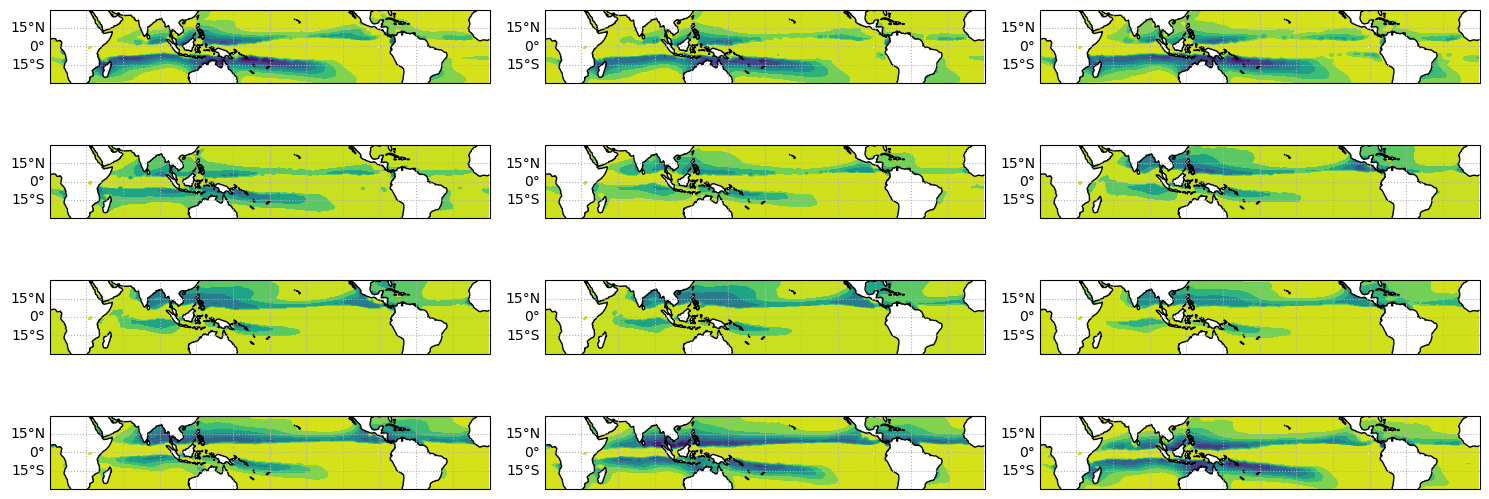

In [128]:
fig, axes = plt.subplots(4, 3, figsize=(15, 6), subplot_kw={"projection": proj}, sharex=True, sharey=True)
xx, yy = np.meshgrid(newds['longitude'], newds['latitude'])
palette = copy(plt.get_cmap("viridis_r"))
palette.set_under("white", 1)
pr = pred.reshape(count.shape)
for i, ax in enumerate(axes.flatten()):
    ax.contourf(xx, yy, np.exp(newds[i, :, :]), transform=trans, cmap=palette)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linestyle=":")
    gl.xlocator = LONLOCATOR
    gl.ylocator = LATLOCATOR
    gl.bottom_labels = False
    gl.right_labels = False
    gl.top_labels = False
    ax.set_extent(EXTENT, crs=trans)
fig.tight_layout()

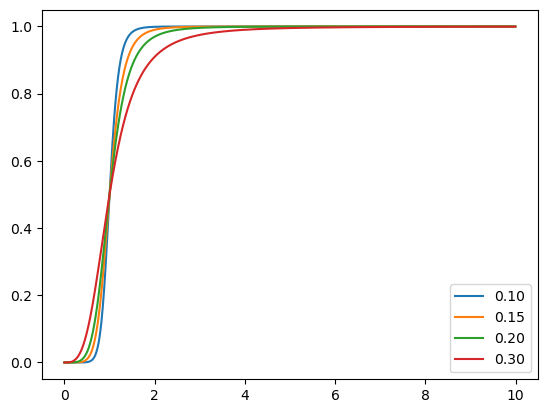

In [141]:
z = np.arange(0., 10, 0.01)
plt.plot(z, 1 / (1 + np.power(z, -1/0.1)), label='0.10')
plt.plot(z, 1 / (1 + np.power(z, -1/0.15)), label='0.15')
plt.plot(z, 1 / (1 + np.power(z, -1/0.2)), label='0.20')
plt.plot(z, 1 / (1 + np.power(z, -1/0.3)), label='0.30')

plt.legend()